In [9]:
! pip install psycopg2
! pip install sklearn

import psycopg2

import numpy as np
import torch

import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import pickle

In [10]:
device_id = "iskra"

In [11]:
def create_connection():
    dbname = 'postgres'
    user = 'postgres'
    password = 'postgres'
    host = '192.168.11.17'
    return psycopg2.connect(dbname=dbname, user=user, password=password, host=host)

In [12]:
def fetch_aggregated_calibration_data():
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"SELECT temperature, humidity, AVG(r0) as r0 " \
				"FROM sensor_calibration_data " \
				"WHERE device_id = %s "
				"GROUP BY temperature, humidity ", (device_id,))
			return np.array(cursor.fetchall(), dtype=float)

In [13]:
def fetch_calibration_data():
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"SELECT temperature, humidity, r0 " \
				"FROM sensor_calibration_data " \
				"WHERE r0 > 40 AND device_id = %s ", (device_id,))
			return np.array(cursor.fetchall(), dtype=float)

In [14]:
def fetch_calibration_data_with_id():
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"SELECT id, temperature, humidity, r0 " \
				"FROM sensor_calibration_data " \
				"WHERE r0 > 40 AND device_id = %s ", (device_id,))
			return np.array(cursor.fetchall(), dtype=float)

def fetch_r0_change_data():
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"SELECT p.id, n.r0 - p.r0 r0 " \
                "FROM sensor_calibration_data n " \
                "JOIN sensor_calibration_data p ON (n.id = p.id + 1) ")
			return np.array(cursor.fetchall(), dtype=float)

def get_outliers():
    data = fetch_r0_change_data()
    r0_change = data[:,1].reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(r0_change)
    r0_change_standard = scaler.transform(r0_change)
    extended_data = np.hstack((data, r0_change_standard))
    outliers_mask = (extended_data[:, 2] < -5) | (extended_data[:, 2] > 5)
    outliers_id = data[outliers_mask][:, 0].astype(int)
    return outliers_id

def clean_up_db():
	outliers = tuple([row for row in get_outliers().tolist()])
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"DELETE " \
                "FROM sensor_calibration_data " \
                "WHERE id in %s", (outliers,))
			connection.commit()


def fetch_clean_calibration_data():
	outliers = get_outliers()
	calibration_data = fetch_calibration_data_with_id()
	outliers_mask = np.isin(calibration_data[:, 0], outliers)
	return calibration_data[~outliers_mask][:, 1:]

In [15]:
len(get_outliers())

80

In [16]:
#if len(get_outliers()) > 0:
#    clean_up_db()

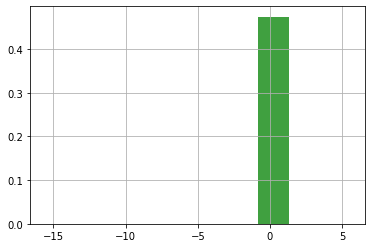

In [17]:
import matplotlib.pyplot as plt

data = fetch_r0_change_data()

x = data[:,1].reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(x)
#x = scaler.transform(x)

#extended = np.hstack((data, x))
#mask = (extended[:, 2] > 5) | (extended[:, 2] < -5)
#outliers = extended[mask]
#x = data[~mask][:,1].reshape(-1, 1)

# the histogram of the data
n, bins, patches = plt.hist(x, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

In [18]:
def aggregateData(train):
    grouped = {}
    for t, h, r0 in train:
        if (t , h) in grouped.keys():
            grouped[(t, h)].append(r0)
        else:
            grouped[(t, h)] = [r0]
    averaged = [(t, h, sum(grouped[(t, h)]) / len(grouped[(t, h)])) for (t, h) in grouped.keys()]
    return np.array(averaged, dtype=float)

In [19]:
def buildModel(degree, train):
    pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())
    pipe.fit(train[:,:-1], train[:,-1])
    return pipe

In [20]:
def runExperiment(degree = 2, aggregate_train_data = False, clean_data = False):
    data = fetch_clean_calibration_data() if clean_data else fetch_calibration_data()
    data = aggregateData(data) if aggregate_train_data else data
    train, test = train_test_split(data)    
    pipe = buildModel(degree, train)
    train_score = pipe.score(train[:,:-1], train[:,-1])
    test_score = pipe.score(test[:,:-1], test[:,-1])
    return (train_score, test_score)

In [26]:
param_grid = {'degree': [1, 2, 3], 'aggregate_train_data': [True], 'clean_data': [True, False] }

results = [(test_case, runExperiment(**test_case))for test_case in ParameterGrid(param_grid)]
results.sort(key=lambda p: p[1][1], reverse=True)
for result in results:
        print(result)

({'aggregate_train_data': True, 'clean_data': False, 'degree': 3}, (0.96009089587539, 0.9543286303474927))
({'aggregate_train_data': True, 'clean_data': True, 'degree': 3}, (0.9602126352148825, 0.9535744097542439))
({'aggregate_train_data': True, 'clean_data': False, 'degree': 2}, (0.9427536351946979, 0.9404308452423575))
({'aggregate_train_data': True, 'clean_data': True, 'degree': 2}, (0.9442856079467375, 0.93596564856065))
({'aggregate_train_data': True, 'clean_data': False, 'degree': 1}, (0.8910839771972081, 0.8945461874066658))
({'aggregate_train_data': True, 'clean_data': True, 'degree': 1}, (0.893261044190376, 0.8876162142556238))


In [27]:
plot_data = fetch_aggregated_calibration_data()
#model = buildModel(2, aggregateData(plot_data))
#model = buildModel(10, plot_data)

In [28]:
model = buildModel(2, plot_data)
model.predict(np.array([[23.7, 85.4]]))

array([62.45926787])

(80, 40)
(3200, 2)


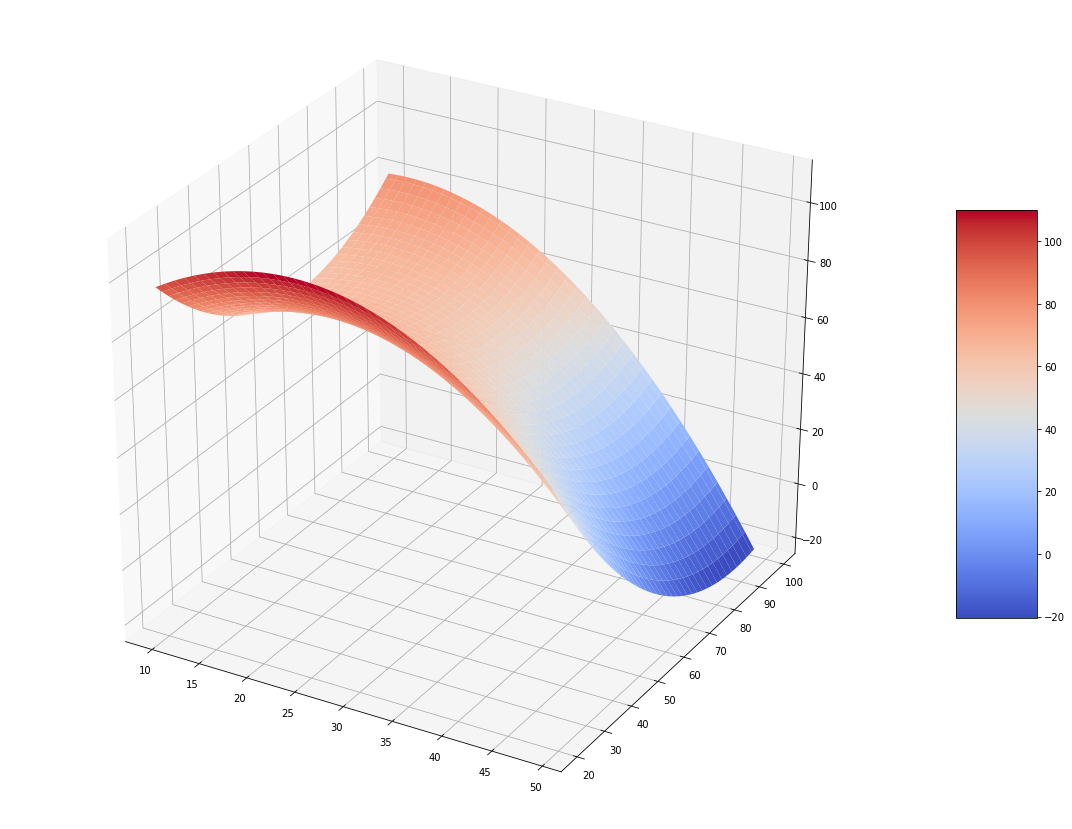

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(20, 15)

# Make data.
X = np.arange(10, 50, 1)
Y = np.arange(20, 100, 1)
#print(X, Y)
X, Y = np.meshgrid(X, Y)

print(X.shape)
XYpairs = np.dstack([X, Y]).reshape(-1, 2)
print(XYpairs.shape)
Z = model.predict(XYpairs)
Z = Z.reshape(X.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

#plot_dots = plot_data
#print(plot_dots.shape)
#ax.scatter(plot_dots[:,0], plot_dots[:,1], plot_dots[:,2], cmap=cm.coolwarm )

plt.show()

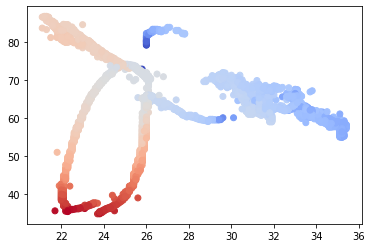

In [25]:
zdata = plot_data[:,-1]
xdata = plot_data[:, 0]
ydata = plot_data[:, 1]
plt.scatter(xdata, ydata, c=zdata, cmap=cm.coolwarm);